## Objective - To predict 'suicidal comments' posted on Reddit platform 

The dataset is taken from : https://www.kaggle.com/

Table of Contents     
1. Import libraries
2. Load the data 
3. Class-label Distribution
4. Pre-processing Text Data 
5. Label Encoding of the Class label
6. Splitting the data into Train and Test 
7. Vectorization of text data    
8. Applying Naive Bayes   
9. Performance Metrics to test my model          
10. Top Features    
11. Checking my model on Futute Unseen Data   
12. Inferences and Conclusion

<h2><font color="blue"> 1. Import Libraries

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

<h2><font color="blue"> 2. Load the data 

In [2]:
data= pd.read_csv("Suicide_Detection.csv", nrows= 100000)

In [3]:
data.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


<h2><font color="blue"> 3. Class-label Distribution

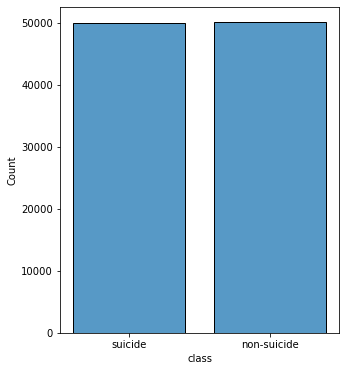

In [4]:
plt.figure(figsize=(5,6))
sns.histplot(data=data, x='class',shrink= 0.8, binwidth=8)
plt.show()

<h2><font color= "blue"> 4. Pre-processing Text Data

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<h3> Checking the missing values

In [6]:
print(data['text'].isnull().values.any())
print("number of nan values",data['text'].isnull().values.sum())

False
number of nan values 0


In [7]:
stop_words= stopwords.words("english")

In [8]:
data["text"]= data["text"].str.lower()

In [9]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

<h3> Text data cleaning, removing punctuations, spaces, numbers and converting the text data into lowercase

In [10]:
#code references from www.appliedaicourse.com
import re
def preprocessing_txt(text):
    clean_text=[]
    tokens= []
    for words in tqdm(text):
        words= re.sub(r"won't" ,"will not" , words)
        words= re.sub(r"can\'t", "can not",words )
        words = re.sub(r"n\'t", " not", words)
        words = re.sub(r"\'re", " are", words)
        words = re.sub(r"\'s", " is", words)
        words = re.sub(r"\'d", " would", words)
        words = re.sub(r"\'ll", " will", words)
        words = re.sub(r"\'t", " not", words)
        words = re.sub(r"\'ve", " have", words)
        words = re.sub(r"\'m", " am", words)
        words= re.sub(r"\d+","",words)
        words = words.replace("im", "I am")
        words= words.replace("\\r", " ")
        words= words.replace("\\n", " ")
        words= words.replace('\\"', ' ')
        words= re.sub("[^A-Za-z0-9]+", " ", words)
        words = ' '.join(i for i in words.split() if i.lower() not in stop_words)
        clean_text.append(words.lower().strip())
        
    return clean_text
                             
data["cleaned_text"]= preprocessing_txt(data["text"])

100%|██████████| 100000/100000 [01:08<00:00, 1453.56it/s]


<h3> Tokenization

In [11]:
#https://pythonhealthcare.org/2018/12/14/101-pre-processing-data-tokenization-stemming-and-removal-of-stop-words/
def identify_tokens(row):
    texts = row['cleaned_text']
    tokens = nltk.word_tokenize(texts)
    token_words = [w for w in tokens]
    return token_words

data['tokenized_words'] = data.apply(identify_tokens, axis=1)

<h3> Stemming

In [12]:
#https://pythonhealthcare.org/2018/12/14/101-pre-processing-data-tokenization-stemming-and-removal-of-stop-words/
def stem_list(row):
    porter= PorterStemmer()
    my_list = row['tokenized_words']
    stemmed_list = [porter.stem(word) for word in my_list]
    return stemmed_list

data['stemmed_words'] = data.apply(stem_list, axis=1)

In [13]:
def rejoin_words(row):
    my_list = row['stemmed_words']
    joined_words = ( " ".join(my_list))
    return joined_words

data['processed_comments'] = data.apply(rejoin_words, axis=1)

In [14]:
data.head()

,Unnamed: 0,text,class,cleaned_text,tokenized_words,stemmed_words,processed_comments
0,2,ex wife threatening suiciderecently i left my ...,suicide,ex wife threatening suiciderecently left wife ...,"[ex, wife, threatening, suiciderecently, left,...","[ex, wife, threaten, suiciderec, left, wife, g...",ex wife threaten suiciderec left wife good che...
1,3,am i weird i don't get affected by compliments...,non-suicide,weird get affected compli aments coming someon...,"[weird, get, affected, compli, aments, coming,...","[weird, get, affect, compli, ament, come, some...",weird get affect compli ament come someon know...
2,4,finally 2020 is almost over... so i can never ...,non-suicide,finally almost never hear bad year ever swear ...,"[finally, almost, never, hear, bad, year, ever...","[final, almost, never, hear, bad, year, ever, ...",final almost never hear bad year ever swear fu...
3,8,i need helpjust help me im crying so hard,suicide,need helpjust help crying hard,"[need, helpjust, help, crying, hard]","[need, helpjust, help, cri, hard]",need helpjust help cri hard
4,9,"i’m so losthello, my name is adam (16) and i’v...",suicide,losthello name adam struggling years afraid pa...,"[losthello, name, adam, struggling, years, afr...","[losthello, name, adam, struggl, year, afraid,...",losthello name adam struggl year afraid past y...


<h2><font color="blue"> 5. Label Encoding of the Class-label

In [15]:
label= preprocessing.LabelEncoder()
data["target"]= label.fit_transform(data["class"])


In [16]:
data.head()

,Unnamed: 0,text,class,cleaned_text,tokenized_words,stemmed_words,processed_comments,target
0,2,ex wife threatening suiciderecently i left my ...,suicide,ex wife threatening suiciderecently left wife ...,"[ex, wife, threatening, suiciderecently, left,...","[ex, wife, threaten, suiciderec, left, wife, g...",ex wife threaten suiciderec left wife good che...,1
1,3,am i weird i don't get affected by compliments...,non-suicide,weird get affected compli aments coming someon...,"[weird, get, affected, compli, aments, coming,...","[weird, get, affect, compli, ament, come, some...",weird get affect compli ament come someon know...,0
2,4,finally 2020 is almost over... so i can never ...,non-suicide,finally almost never hear bad year ever swear ...,"[finally, almost, never, hear, bad, year, ever...","[final, almost, never, hear, bad, year, ever, ...",final almost never hear bad year ever swear fu...,0
3,8,i need helpjust help me im crying so hard,suicide,need helpjust help crying hard,"[need, helpjust, help, crying, hard]","[need, helpjust, help, cri, hard]",need helpjust help cri hard,1
4,9,"i’m so losthello, my name is adam (16) and i’v...",suicide,losthello name adam struggling years afraid pa...,"[losthello, name, adam, struggling, years, afr...","[losthello, name, adam, struggl, year, afraid,...",losthello name adam struggl year afraid past y...,1


<h3> Checking the missing values

In [17]:
print(data['class'].isnull().values.any())
print("number of nan values",data['class'].isnull().values.sum())

False
number of nan values 0


<h2><font color="blue"> 6. Splitting the data to Train and Test

<h4> I will be using GridSearchCV for hyperparameter tuning. GridSearchCV internally creates the cv set and so I am not splitting my data into train, cv and test. The model will learn better if it gets more train data. 

In [18]:
X= data["processed_comments"]
Y= data["target"]

In [19]:
X_train, X_test,Y_train,Y_test= train_test_split(X,Y, test_size=0.33,random_state=0)


<h2> <font color= "blue"> 7. Vectorization of Text data

<h3> Bag of Words

In [20]:
vectorizer= CountVectorizer()
text_data_1= vectorizer.fit(X_train)
xtrain_1= vectorizer.transform(X_train)
xtest_1= vectorizer.transform(X_test)
print(xtrain_1.shape, Y_train.shape)
print(xtest_1.shape, Y_test.shape)

(67000, 54547) (67000,)
(33000, 54547) (33000,)


<h3> TFIDF 

In [21]:
model_2= TfidfVectorizer()
text_data_2= model_2.fit(X_train)
xtrain_2= text_data_2.transform(X_train)
xtest_2= text_data_2.transform(X_test.values)
print(xtrain_2.shape, Y_train.shape)
print(xtest_2.shape, Y_test.shape)


(67000, 54547) (67000,)
(33000, 54547) (33000,)


<h2><font color="blue"> 8. Applying Naive Bayes

<h3> SET 1: BoW 

<h3> Hyperparameter tuning

In [22]:
parameters= {"alpha": [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]}
clf1= GridSearchCV(MultinomialNB(), parameters, cv=10, return_train_score= True)
clf1.fit(xtrain_1,Y_train)
alpha1= clf1.best_params_["alpha"]
score1= clf1.best_score_
print("Best alpha value is ", alpha1)
print("Best score value is ", score1)

Best alpha value is  0.1
Best score value is  0.897044776119403


In [23]:
auc_train_1= clf1.cv_results_['mean_train_score']
auc_test_1= clf1.cv_results_["mean_test_score"]

100%|██████████| 20/20 [00:00<?, ?it/s]


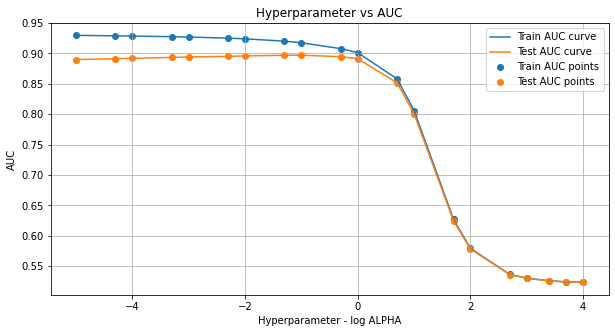

In [24]:
#code reference taken from https://www.kaggle.com/nikhilparmar9/naive-bayes-donorschoose-dataset
log_alpha=[]
alpha_vals= [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]
for i in tqdm(alpha_vals):
    c= np.log10(i)
    log_alpha.append(c)
plt.figure(figsize=(10,5))
plt.scatter(log_alpha,auc_train_1, label= "Train AUC points")
plt.scatter(log_alpha,auc_test_1, label= "Test AUC points")
plt.plot(log_alpha,auc_train_1, label= "Train AUC curve")
plt.plot(log_alpha,auc_test_1, label= "Test AUC curve")
plt.legend()
plt.xlabel("Hyperparameter - log ALPHA")
plt.ylabel("AUC")
plt.title("Hyperparameter vs AUC")
plt.grid()
plt.show()


<h4> After performing hyperparameter tuning using GridSearchCV, the best value of alpha is found. Now the train data is trained using the best hyperparameter and then the mean of train scores and test scores are computed. The range of alpha is converted to log alpha. All the mean train and test scores are plotted against the log values of alpha.  

<h3> Accuracy Score

In [25]:
model_1= MultinomialNB(0.1)
model_1.fit(xtrain_1, Y_train)
y_pred_1= model_1.predict(xtest_1)
acc_1= accuracy_score(y_pred_1, Y_test)
acc_percent= round(acc_1*100,3)
print("Accuacy is", acc_percent,"%")

Accuacy is 89.409 %


<h4> The best hyperparameter is used to fit the model on train data. Then it predicts the classes (positive or negative) of the test data. The accuracy score tells the number of correct classification for the test data given the actual values of the classes.

<h2> <font color="blue"> 9. Performance Metrics to test my model

<h3> ROC Curve

<Figure size 1440x720 with 0 Axes>

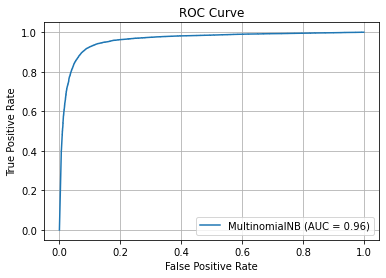

In [26]:
model_1 = MultinomialNB(0.1)
model_1.fit(xtrain_1, Y_train)
plt.figure(figsize=(20,10))
metrics.plot_roc_curve(model_1, xtest_1, Y_test)
plt.title("ROC Curve")
plt.grid()
plt.show()

<h4> The ROC curve gives an idea of how many positive points are correctly classified as positive. Using Bag of Words, the AUC score is 0.96 which is very close to 1. The ideal AUC value is 1. So, it can be said that my model performance is good. 

<h3> Confusion Matrix

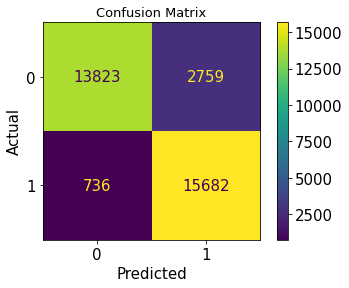

In [28]:
model_1= MultinomialNB(0.1)
model_1.fit(xtrain_1, Y_train)
plot_confusion_matrix(model_1, xtest_1,Y_test)
#https://stackoverflow.com/questions/50543885/how-to-remove-grid-lines-on-image-in-python/50652936
plt.rcParams["axes.grid"] = False
plt.rcParams["font.size"]= 15
plt.title("Confusion Matrix", fontsize= 13)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

<h4> From the confusion matrix, true negative= 13823, false positive= 2759, false negative= 736 and true positive= 15682.  

In [29]:
y_te_1= []
for i in Y_test:
    test= float(i)
    y_te_1.append(test)
#print(y_te)

In [30]:
def pred(xtrain_1,xtest_1,Y_train, Y_test, y_te_1,threshold):
    y_pred_1= []
    model_1= MultinomialNB(0.1)
    model_1.fit(xtrain_1, Y_train)
    
    y= model_1.predict_proba(xtest_1)[:,1]
    for i in range(len(y)):
        if y[i]>=threshold:
            y[i]= 1
        else:
            y[i]= 0
        y_pred_1.append(y[i])
    
    
    tp=0
    tn=0
    fp=0
    fn=0
    l= list(Y_test)
    for i in range(len(y_pred_1)):
        if(y_pred_1[i]==1) and (y_te_1[i]==1):
            tp+=1
        if(y_pred_1[i]==0) and (y_te_1[i]==0):
            tn+=1
        if(y_pred_1[i]==0) and (y_te_1[i]==1):
            fn+=1
        if(y_pred_1[i]==1) and (y_te_1[i]==0):
            fp+=1
    return {"true_negative": tn, "false_positive": fp, "false_negative":fn, "true_positive":tp}
            
        
            
threshold = 0.5 
confusion_matrix_1=pred(xtrain_1,xtest_1,Y_train, Y_test, y_te_1, threshold)

    

<h3> F1 Score

In [31]:
Precision_1= confusion_matrix_1["true_positive"]/(confusion_matrix_1["true_positive"]+ confusion_matrix_1["false_positive"])
Recall_1= confusion_matrix_1["true_positive"]/(confusion_matrix_1["true_positive"]+ confusion_matrix_1["false_negative"])
F_Score_1 = 2*Precision_1*Recall_1/(Precision_1+Recall_1)
F1_Score_1 = round(F_Score_1,3)
print("F1 score =", F1_Score_1)

F1 score = 0.9


<h4> The best value of F1 score is 1. The F1 score of my model is 0.9 which is close to 1. This indicates that my model has low false positives and low false negatives.

<h3> Mean Squared Error

In [32]:
def mse(xtrain_1, xtest_1,Y_test, Y_train,y_te_1,threshold):
    sq_error=0
    y_pred= []
    model_1= MultinomialNB(0.1)
    model_1.fit(xtrain_1, Y_train)
    
    y1= model_1.predict_proba(xtest_1)[:,1]
    for i in range(len(y1)):
        if y1[i]>=threshold:
            y1[i]= 1
        else:
            y1[i]= 0
        y_pred.append(y1[i])
    for i in range(len(y_pred)):
        sq_error+= (y_te_1[i]-y_pred[i])**2
    MSE= sq_error/len(y_pred)
    MSE_1= round(MSE,3)
    return MSE_1
threshold= 0.5
mean_sq_error= mse(xtrain_1, xtest_1,Y_test, Y_train,y_te_1, threshold)
print("Mean Squared Error =", mean_sq_error)
    

Mean Squared Error = 0.106


<h4> Mean Squared error is the mean of the square difference of the predicted values and actual values. Lower value of MSE means the model performance is good.The value of MSE for my model is 0.106 when I used BoW for vectorization. 

<h3> SET 2: TFIDF

<h3> Hyperparameter tuning 

In [33]:
parameters = {"alpha":[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]}
clf2= GridSearchCV(MultinomialNB(),parameters, cv=15, scoring= "roc_auc", return_train_score= True)
clf2.fit(xtrain_2, Y_train)
alpha2= clf2.best_params_["alpha"] 
score2= clf2.best_score_
print("Best alpha value is ", alpha2)
print("Best score value is ", score2)

Best alpha value is  0.05
Best score value is  0.9696553077793225


In [34]:
auc_train_2= clf2.cv_results_['mean_train_score']
auc_test_2= clf2.cv_results_["mean_test_score"]

100%|██████████| 20/20 [00:00<00:00, 2504.96it/s]


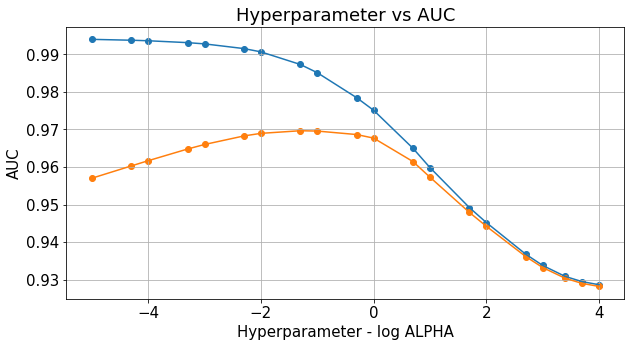

In [35]:
#code reference taken from https://www.kaggle.com/nikhilparmar9/naive-bayes-donorschoose-dataset
log_alpha=[]
alpha_vals= [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]
for i in tqdm(alpha_vals):
    c= np.log10(i)
    log_alpha.append(c)
plt.figure(figsize=(10,5))
plt.scatter(log_alpha,auc_train_2, label= "Train AUC curve")
plt.scatter(log_alpha,auc_test_2, label= "Test AUC curve")
plt.plot(log_alpha,auc_train_2, label= "Train AUC curve")
plt.plot(log_alpha,auc_test_2, label= "Test AUC curve")
plt.xlabel("Hyperparameter - log ALPHA")
plt.ylabel("AUC")
plt.title("Hyperparameter vs AUC")
plt.grid()
plt.show()


<h4> The best value of the hyperparameter alpha is 0.05 in case of TFIDF. The AUC axis represents the mean scores of train and test data. Lower value of AUC corresponds to higher value of log alpha from the plot.

<h3> Accuracy Score

In [36]:
model_2= MultinomialNB(0.05)
model_2.fit(xtrain_2, Y_train)
y_pred_2= model_2.predict(xtest_2)
acc_2= accuracy_score(y_pred_2, Y_test)
acc_percent= round(acc_2*100,3)
print("Accuacy is", acc_percent,"%")

Accuacy is 89.752 %


<h4> The accuracy of the test data is 89.752% for TFIDF. This value is very close to the accuracy score for BoW. 

<h3> ROC Curve

<Figure size 1440x720 with 0 Axes>

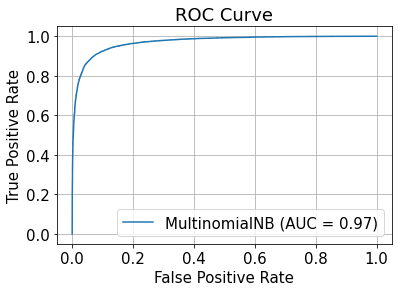

In [37]:
model = MultinomialNB(0.05)
model.fit(xtrain_2, Y_train)
plt.figure(figsize=(20,10))
metrics.plot_roc_curve(model, xtest_2, Y_test)
plt.title("ROC Curve")
plt.grid()
plt.show()

<h4> From the plot, I have got AUC value = 0.97 which is very close to 1. This implies the performance of my model is good. 

<h3> Confusion Matrix

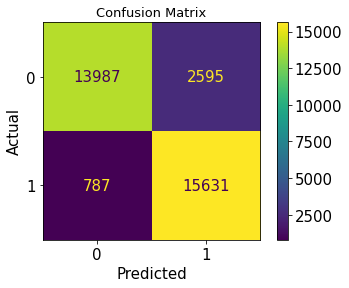

In [38]:
model_2= MultinomialNB(0.05)
model_2.fit(xtrain_2, Y_train)
plot_confusion_matrix(model_2, xtest_2,Y_test)
#https://stackoverflow.com/questions/50543885/how-to-remove-grid-lines-on-image-in-python/50652936
plt.rcParams["axes.grid"] = False
plt.rcParams["font.size"]= 15
plt.title("Confusion Matrix", fontsize= 13)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


<h4> From the confusion matrix I can say that although there are many misclassifications of positive and negative classes, the number of correctly classified comments for both suicidal and non-suicidal comments is comparatively more than the number of misclassified comments. 

In [39]:
y_te_2= []
for i in Y_test:
    test= float(i)
    y_te_2.append(test)
#print(y_te)

In [40]:
def pred(xtrain_2,xtest_2,Y_train, Y_test, y_te_2,threshold):
    y_pred_2= []
    model_2= MultinomialNB(0.05)
    model_2.fit(xtrain_2, Y_train)
    
    y= model_2.predict_proba(xtest_2)[:,1]
    for i in range(len(y)):
        if y[i]>=threshold:
            y[i]= 1
        else:
            y[i]= 0
        y_pred_2.append(y[i])
    
    
    tp=0
    tn=0
    fp=0
    fn=0
    l= list(Y_test)
    for i in range(len(y_pred_2)):
        if(y_pred_2[i]==1) and (y_te_2[i]==1):
            tp+=1
        if(y_pred_2[i]==0) and (y_te_2[i]==0):
            tn+=1
        if(y_pred_2[i]==0) and (y_te_2[i]==1):
            fn+=1
        if(y_pred_2[i]==1) and (y_te_2[i]==0):
            fp+=1
    return {"true_negative": tn, "false_positive": fp, "false_negative":fn, "true_positive":tp}
            
        
            
threshold = 0.5 
confusion_matrix_2=pred(xtrain_2,xtest_2,Y_train, Y_test, y_te_2, threshold)
    

<h3> F1 Score

In [41]:
Precision_2= confusion_matrix_2["true_positive"]/(confusion_matrix_2["true_positive"]+ confusion_matrix_2["false_positive"])
Recall_2= confusion_matrix_2["true_positive"]/(confusion_matrix_2["true_positive"]+ confusion_matrix_2["false_negative"])
F_Score_2 = 2*Precision_2*Recall_2/(Precision_2+Recall_2)
F1_Score_2 = round(F_Score_2,3)
print("F1 score =", F1_Score_2)

F1 score = 0.902


<h4> The F1 score of my model is 0.9 which is close to 1. This means that my data has low false positive and low false negative values. 

<h3> Mean Squared Error

In [42]:
def mse(xtrain_2, xtest_2,Y_test, Y_train,y_te_2,threshold):
    sq_error=0
    y_pred= []
    model_2= MultinomialNB(0.05)
    model_2.fit(xtrain_2, Y_train)
    
    y2= model_2.predict_proba(xtest_2)[:,1]
    for i in range(len(y2)):
        if y2[i]>=threshold:
            y2[i]= 1
        else:
            y2[i]= 0
        y_pred.append(y2[i])
    for i in range(len(y_pred)):
        sq_error+= (y_te_2[i]-y_pred[i])**2
    MSE= sq_error/len(y_pred)
    MSE_2= round(MSE,3)
    return MSE_2
threshold= 0.5
mean_sq_error= mse(xtrain_2, xtest_2,Y_test, Y_train,y_te_2, threshold)
print("Mean Squared Error =", mean_sq_error)
    

Mean Squared Error = 0.103


<h4> A lower value of MSE implies better performance of a model. My model gives MSE value of 0.103 which can be considered as low.

<h2><font color="blue"> 10. Top Features

<h3> SET1: BoW

In [145]:
get_features= []
for i in text_data_1.get_feature_names():
    get_features.append(i)
#print(get_features)
top_features={}
model= MultinomialNB(alpha=0.1)
model.fit(xtrain_1,Y_train)
#code reference taken from https://www.kaggle.com/nikhilparmar9/naive-bayes-donorschoose-dataset
for j in range(len(get_features)):
    top_features[j]= model.feature_log_prob_[1,j]
final_features = pd.DataFrame({'feature_log_probability' : list(top_features.values()),'feature_names' : list(get_features)})
top = final_features.sort_values(by = ['feature_log_probability'])
top.tail(50)[1::5]

,feature_log_probability,feature_names
43674,-5.706955,someon
3030,-5.640915,anyth
11978,-5.557765,depress
46336,-5.496967,talk
31320,-5.357617,much
45512,-5.208415,suicid
38946,-5.102800,realli
53836,-4.974589,year
53256,-4.730433,would
26448,-4.511299,know


<h3> SET 2: TFIDF

In [146]:
get_features= []
for i in text_data_2.get_feature_names():
    get_features.append(i)
#print(get_features)
top_features={}
model= MultinomialNB(alpha=0.05)
model.fit(xtrain_2,Y_train)
#code reference taken from https://www.kaggle.com/nikhilparmar9/naive-bayes-donorschoose-dataset
for j in range(len(get_features)):
    top_features[j]= model.feature_log_prob_[1,j]
final_features = pd.DataFrame({'feature_log_probability' : list(top_features.values()),'feature_names' : list(get_features)})
top = final_features.sort_values(by = ['feature_log_probability'])
top.tail(50)[1::5]

,feature_log_probability,feature_names
22096,-5.962450,hi
32960,-5.901474,noth
10174,-5.880903,could
11978,-5.816067,depress
11298,-5.662734,day
38946,-5.549400,realli
33927,-5.498702,one
27833,-5.461317,live
53256,-5.314052,would
27656,-5.086128,like


<h4> These are some of the top words that have been used in suicidal comments.

<h2><font color="blue"> 11. Checking my model on Futute Unseen Data

In [43]:
from sklearn.pipeline import make_pipeline
#code references taken from https://jakevdp.github.io/PythonDataScienceHandbook/05.05-naive-bayes.html
model = make_pipeline(TfidfVectorizer(), MultinomialNB(alpha = 0.05))
model.fit(X_train, Y_train)
labels = model.predict(X_test)
def pred(sentence, train= data, model= model):
    k= model.predict([sentence])
    return train["class"][k[0]]

In [44]:
pred("I am sad and depressed. Help me.")

'suicide'

In [45]:
pred("I feel good")

'non-suicide'

<h4> My model has predicted the correct class label of unseen comments. This indicates that the model is reliable. 

<h2><font color="blue"> 12. Inferences and Conclusion

1. Text Preprocessing is the most important step of cleaning the text alongwith the application of tokenization and stemming. 

2. There were no missing values in the data.

3. The accuracy score is near about 90% for both set 1 (BoW) and set 2 (TFIDF). 

4. The number of true positives and true negatives are much higher than false positives and false negatives.

5. The squared error in classification of correct positive classes and negative classes are quite low. This shows that my model has correctly classified majority of text data.   



